In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import glob
from scipy.stats import zscore
from plotnine import *
import json
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
import random
import numpy as np
from scipy.stats import ttest_ind

In [35]:
sample_info = pd.read_csv('sample_info_addedfeatures_v4.csv',sep='\t')

In [36]:
#sample_info['ichor_profile_result'] = sample_info['ichor_profile_result'].apply(lambda x:1 if x=='Abnormal' else 0)

In [38]:
#sample_info.to_csv('sample_info_addedfeatures_v5.csv',sep='\t',index=False,header=True)

In [3]:
samples = list(sample_info['CPM.UID'])

#### Feature Engineering

In [4]:
final_added_features = pd.DataFrame()
for sample in samples:
    ratio_file = glob.glob(f'../ratio_files/*{sample.strip()}*')[0]
    coverage_file = glob.glob(f'../coverage_files/*{sample.strip()}*')[0]
    added_features = pd.read_csv(ratio_file,sep='\t').set_index('Unnamed: 0')
    col_names = added_features.columns
    added_features = pd.DataFrame(added_features.apply(zscore,axis=1)[0]).transpose()
    added_features.columns = col_names
    added_features.index = [sample]
    
    coverage_df = pd.read_csv(coverage_file,sep='\t',header=None).set_index(0)
    mt_coverage = coverage_df.loc['MT'][3]
    coverage_df.drop('MT',inplace=True)
    total_length = sum(coverage_df[2])
    coverage_df['mult'] = coverage_df[2]*coverage_df[3] 
    avg_nuclear_coverage = sum(coverage_df['mult'])/total_length
    
    #mt copy number
    mt_cp_number = (2*mt_coverage)/avg_nuclear_coverage
    added_features['mt_copy_number'] = mt_cp_number
    
    final_added_features = pd.concat([final_added_features,added_features])

In [5]:
final_added_features.reset_index(inplace=True)
final_added_features.rename(columns={'index':'CPM.UID'},inplace=True)

In [6]:
sample_info = sample_info.merge(final_added_features,on='CPM.UID')

In [7]:
new_cols = [col for col in sample_info.columns if col != 'cancer'] + ['cancer']
sample_info = sample_info[new_cols]

In [74]:
chromosomes = list(sample_info.columns[23:-2])

In [81]:
mt_median_dict = {}
for sample in samples:
    print(sample)
    json_loc = glob.glob('../fragsize_jsons/*'+sample.strip()+'*')[0]
    f = open(json_loc)
    json_dict = json.load(f)
    frag_sizes = json_dict['MT']
    median = statistics.median(frag_sizes)
    mt_median_dict[sample] = median

CPM00009466
CPM00010023
CPM00010162
CPM00014150
CPM00013994
CPM00014196
CPM00018782
CPM00020195
CPM00021296
CPM00005237
CPM00007590
CPM00007090
CPM00020423
CPM00021797
CPM00009084
CPM00020428
CPM00016461
CPM00007351
CPM00020923
CPM00006300
CPM00014875
CPM00020143
CPM00020807
CPM00021286
CPM00022115
CPM00009467
CPM00011849
CPM00011851
CPM00013545
CPM00018619
CPM00018705
CPM00018811
CPM00019420
CPM00021417
CPM00007659
CPM00010094
CPM00015881
CPM00019591
CPM00021541
CPM00002066
CPM00013771
CPM00007071
CPM00009747
CPM00018706
CPM00019339
CPM00022771
CPM00009001
CPM00017466
CPM00022116
CPM00008709
CPM00011650
CPM00012320
CPM00013846 
CPM00017950
CPM00018469
CPM00019098
CPM00009465
CPM00007325
CPM00020422
CPM00022117
CPM00022772
CPM00022118
CPM00009805
CPM00009029
CPM00020421
CPM00011754
CPM00020419
CPM00019054
CPM00019463
CPM00022119
CPM00022120
CPM00020420
CPM00011648
CPM00010410
CPM00010412
CPM00010411
CPM00010413
CPM00011386
CPM00011381
CPM00011387
CPM00017273
CPM00013753
CPM00012465
CPM

In [85]:
mt_medians = pd.DataFrame(mt_median_dict,index=[0]).transpose().reset_index()
mt_medians.columns = ['CPM.UID','mt_median_fragsize']
sample_info = sample_info.merge(mt_medians,on='CPM.UID')
new_cols = [col for col in sample_info.columns if col != 'cancer'] + ['cancer']
sample_info = sample_info[new_cols]

In [87]:
#sample_info.to_csv('sample_info_addedfeatures_v3.csv',sep='\t',index=False,header=True)

In [109]:
final_mean_df = pd.DataFrame()
for sample in samples:
    mean_dict = {}
    json_loc = glob.glob('../fragsize_jsons/*'+sample.strip()+'*')[0]
    f = open(json_loc)
    json_dict = json.load(f)
    for chrom in chromosomes:
        frag_sizes = json_dict[chrom]
        mean = statistics.mean(frag_sizes)
        mean_dict[chrom] = mean
    
    mean_df = pd.DataFrame(mean_dict,index=[sample])
    mean_df.columns = [x + '_mean_fragsize' for x in list(mean_df.columns)]
    final_mean_df = pd.concat([final_mean_df,mean_df])

CPM00009466
CPM00010023
CPM00010162
CPM00014150
CPM00013994
CPM00014196
CPM00018782
CPM00020195
CPM00021296
CPM00005237
CPM00007590
CPM00007090
CPM00020423
CPM00021797
CPM00009084
CPM00020428
CPM00016461
CPM00007351
CPM00020923
CPM00006300
CPM00014875
CPM00020143
CPM00020807
CPM00021286
CPM00022115
CPM00009467
CPM00011849
CPM00011851
CPM00013545
CPM00018619
CPM00018705
CPM00018811
CPM00019420
CPM00021417
CPM00007659
CPM00010094
CPM00015881
CPM00019591
CPM00021541
CPM00002066
CPM00013771
CPM00007071
CPM00009747
CPM00018706
CPM00019339
CPM00022771
CPM00009001
CPM00017466
CPM00022116
CPM00008709
CPM00011650
CPM00012320
CPM00013846 
CPM00017950
CPM00018469
CPM00019098
CPM00009465
CPM00007325
CPM00020422
CPM00022117
CPM00022772
CPM00022118
CPM00009805
CPM00009029
CPM00020421
CPM00011754
CPM00020419
CPM00019054
CPM00019463
CPM00022119
CPM00022120
CPM00020420
CPM00011648
CPM00010410
CPM00010412
CPM00010411
CPM00010413
CPM00011386
CPM00011381
CPM00011387
CPM00017273
CPM00013753
CPM00012465
CPM

In [29]:
ichor = pd.read_csv('ichor_files/cfdna_wgs_samples_CSF_PL_143.txt',sep='\t')

In [30]:
ichor = ichor[['Sample.ID','Profile.result']]
ichor.columns = ['Sample ID','ichor_profile_result']

In [32]:
sample_info = sample_info.merge(ichor,on='Sample ID')
new_cols = [col for col in sample_info.columns if col != 'cancer'] + ['cancer']
sample_info = sample_info[new_cols]

In [34]:
#sample_info.to_csv('sample_info_addedfeatures_v4.csv',sep='\t',index=False,header=True)

In [111]:
final_mean_df.reset_index(inplace=True)
final_mean_df.rename(columns={'index':'CPM.UID'},inplace=True)
sample_info = sample_info.merge(final_mean_df,on='CPM.UID')
new_cols = [col for col in sample_info.columns if col != 'cancer'] + ['cancer']
sample_info = sample_info[new_cols]

In [861]:
#sample_info.to_csv('sample_info_addedfeatures_v2.csv',sep='\t',index=False,header=True)

In [858]:
#sample_info['CMA_abnormal'] = sample_info['CMA result'].apply(lambda x:1 if x == 'Abnormal' else 0)

In [2]:
#sample_info = pd.read_csv('sample_info_addedfeatures_v2.csv',sep='\t')

In [984]:
#sample_info = sample_info[sample_info['Timepoint'] != 'On therapy']

In [986]:
#sample_info['Tumor type'] = sample_info['Tumor type'].apply(lambda x:x if x != 'Thyroid tumor' else 'Other sarcoma')

In [3]:
sample_info = pd.read_csv('sample_info_addedfeatures_v5.csv',sep='\t')

In [4]:
X = sample_info.iloc[:,:-1]
y = sample_info.cancer

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,stratify=X['Tumor type'])

#### EDA on Training Data

In [4]:
#adding the label back for EDA

X_train['Cancer'] = y_train

In [9]:
control_samples = list(X_train[X_train['Tumor type'] == 'Control']['CPM.UID'])
cancer_samples = list(X_train[X_train['Tumor type'] != 'Control']['CPM.UID'])

In [6]:
#code to look at average fragsize across chromosomes for cancer and not cancer

for chrom in list(X_train.columns[23:48]):
    
    mt_control_frag_sizes = []
    for sample in control_samples:
        json_loc = glob.glob('../fragsize_jsons/*'+sample+'*')[0]
        f = open(json_loc)
        json_dict = json.load(f)
        frag_sizes = json_dict[chrom]
        mt_control_frag_sizes = mt_control_frag_sizes + frag_sizes

    mt_cancer_frag_sizes = []
    for sample in cancer_samples:
        json_loc = glob.glob('../fragsize_jsons/*'+sample+'*')[0]
        f = open(json_loc)
        json_dict = json.load(f)
        frag_sizes = json_dict[chrom]
        mt_cancer_frag_sizes = mt_cancer_frag_sizes + frag_sizes
    
    print(chrom)
    print('------')
    print('Medians')
    print(f'Normal:{statistics.median(mt_control_frag_sizes)}')
    print(f'Cancer:{statistics.median(mt_cancer_frag_sizes)}')
    print('Means')
    print(f'Normal:{statistics.mean(mt_control_frag_sizes)}')
    print(f'Cancer:{statistics.mean(mt_cancer_frag_sizes)}')
    print('Standard Deviations')
    print(f'Normal:{statistics.stdev(mt_control_frag_sizes)}')
    print(f'Cancer:{statistics.stdev(mt_cancer_frag_sizes)}')
    

1
------
Medians
Normal:167.0
Cancer:166.0
Means
Normal:173.06986666666666
Cancer:174.3914827586207
Standard Deviations
Normal:44.541874483006254
Cancer:48.3302062700563
2
------
Medians
Normal:167.0
Cancer:167.0
Means
Normal:173.8816
Cancer:174.44
Standard Deviations
Normal:44.914933243526434
Cancer:47.67143949641259
3
------
Medians
Normal:168.0
Cancer:167.0
Means
Normal:173.81426666666667
Cancer:175.10120689655173
Standard Deviations
Normal:44.30263046597101
Cancer:48.46848928452956
4
------
Medians
Normal:167.0
Cancer:167.0
Means
Normal:172.69426666666666
Cancer:174.8231379310345
Standard Deviations
Normal:43.3017243579653
Cancer:48.26845822334582
5
------
Medians
Normal:168.0
Cancer:167.0
Means
Normal:172.8272
Cancer:175.05837931034483
Standard Deviations
Normal:43.74451528868938
Cancer:48.45304085009035
6
------
Medians
Normal:167.0
Cancer:167.0
Means
Normal:173.21413333333334
Cancer:174.9386551724138
Standard Deviations
Normal:44.869002409598096
Cancer:48.060912399267686
7
-----

In [60]:
normal_copy_numbers = list(X_train[X_train['Cancer'] == 0][X_train['mt_copy_number'] < 50].mt_copy_number)

/tmp/ipykernel_138018/1031114391.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [58]:
cancer_copy_numbers = list(X_train[X_train['Cancer'] == 1].mt_copy_number)

In [64]:
ttest_ind(normal_copy_numbers,cancer_copy_numbers)

Ttest_indResult(statistic=1.1189813676735574, pvalue=0.2669732497228425)

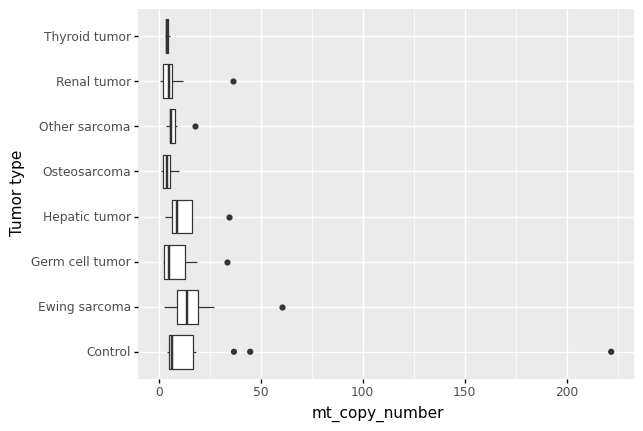

<ggplot: (8756876441549)>

In [73]:
ggplot(X_train) + aes(x='Tumor type',y='mt_copy_number') + geom_boxplot() + coord_flip()

In [39]:
X_train.head().columns

Index(['Sample ID', 'CPM.UID', 'Current.Label', 'Date.drawn',
       'Baseline.sample.Relapse', 'Timepoint', 'CMA available', 'CMA result',
       'Profile.result', 'Stage At Diagnosis', 'Stage at Relapse',
       'Localized.Metastatic', 'Location of Mets', 'Tumor.type', 'Tumor type',
       'TT', 'Sex', 'Age..at.enrollment.',
       'Abnormal.LB.BEFORE.clinical.relapse', 'Relapse Dates on Study',
       'NOTES', 'Oncokids', 'Serial samples analyzed', '1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', 'X', 'Y', 'MT', 'mt_copy_number',
       '1_mean_fragsize', '2_mean_fragsize', '3_mean_fragsize',
       '4_mean_fragsize', '5_mean_fragsize', '6_mean_fragsize',
       '7_mean_fragsize', '8_mean_fragsize', '9_mean_fragsize',
       '10_mean_fragsize', '11_mean_fragsize', '12_mean_fragsize',
       '13_mean_fragsize', '14_mean_fragsize', '15_mean_fragsize',
       '16_mean_fragsize', '17_mean_fragsize', 

In [37]:
X_train[X_train['CMA available'] == 'YES']

#[X_train['CMA_abnormal'] != X_train['Cancer']]

Sample ID      CPM.UID Current.Label  Date.drawn  \
0   CPM00009466-PL-D-20191004_20211104  CPM00009466    ctDNA-1N-1   10/4/2019   
57  CPM00007325-PL-D-20201105_20210901  CPM00007325   ctDNA-7R1-2   11/5/2020   
67  CPM00019054-PL-D-20210429_20211027  CPM00019054    ctDNA-9N-5   4/29/2021   
70  CPM00022120-PL-D-20210831_20220302  CPM00022120    ctDNA-9N-8   8/31/2021   
26           CPM00011849-PL-D_20210720  CPM00011849    ctDNA-2N-3   7/21/2020   
36  CPM00015881-PL-D-20201224_20211104  CPM00015881    ctDNA-3N-2  12/24/2020   
53       CPM00017950-PL-D-1-0_20210824  CPM00017950    ctDNA-7N-5    2/9/2021   
4   CPM00013994-PL-D-20201022_20211109  CPM00013994    ctDNA-1N-5  10/22/2020   
30  CPM00018705-PL-D-20210414_20211109  CPM00018705    ctDNA-2N-7   4/14/2021   
39  CPM00002066-PL-D-20191015_20211104  CPM00002066    ctDNA-3R-1  10/15/2019   
14  CPM00009084-PL-D-20220411_20220526  CPM00009084   ctDNA-1R1-5   4/11/2022   
27           CPM00011851-PL-D_20210720  CPM00011851    ctDNA-2N-4   7/28/2020   
34  CPM00007659-PL-D-20210430_20211111  CPM00007659    ctDNA-2R-2   4/30/2021   
68  CPM00019463-PL-D-20210517_20210909  CPM00019463    ctDNA-9N-6   5/17/2021   
45  CPM00022771-PL-D-20220421_20220526  CPM00022771    ctDNA-5N-5   4/21/2022   
23  CPM00021286-PL-D-20211026_20211202  CPM00021286   ctDNA-2N-12  10/26/2021   
25  CPM00009467-PL-D-20191021_20211104  CPM00009467    ctDNA-2N-2  10/21/2019   
54  CPM00018469-PL-D-20210316_20211004  CPM00018469    ctDNA-7N-6   3/16/2021   
2   CPM00010162-PL-D-20200117_20211109  CPM00010162    ctDNA-1N-3   1/17/2020   
7   CPM00020195-PL-D-20210812_20211111  CPM00020195    ctDNA-1N-8   8/12/2021   
16           CPM00016461-PL-D_20210720  CPM00016461    ctDNA-1R-3    2/1/2021   
3   CPM00014150-PL-D-20201021_20211109  CPM00014150    ctDNA-1N-4  10/21/2020   
48  CPM00022116-PL-D-20211118_20220302  CPM00022116    ctDNA-6N-4  11/18/2021   
11  CPM00007090-PL-D-20191120_20211116  CPM00007090   ctDNA-1R1-2  11/20/2019   
51  CPM00012320-PL-D-20200825_20210909  CPM00012320    ctDNA-7N-3   8/25/2020   
6   CPM00018782-PL-D-20210402_20211111  CPM00018782    ctDNA-1N-7    4/2/2021   
20  CPM00014875-PL-D-20190709_20211129  CPM00014875    ctDNA-2N-1    7/9/2019   
22  CPM00020807-PL-D-20211011_20211129  CPM00020807   ctDNA-2N-11  10/11/2021   
18  CPM00020923-PL-D-20211026_20211129  CPM00020923   ctDNA-1R3-2  10/26/2021   
37  CPM00019591-PL-D-20210714_20211104  CPM00019591    ctDNA-3N-3   7/14/2021   
47  CPM00017466-PL-D-20210121_20211202  CPM00017466    ctDNA-6N-3   1/21/2021   
59  CPM00022117-PL-D-20211116_20220302  CPM00022117   ctDNA-7R1-4  11/16/2021   
35  CPM00010094-PL-D-20200123_20211104  CPM00010094    ctDNA-3N-1   1/23/2020   
63  CPM00009029-PL-D-20190807_20220330  CPM00009029    ctDNA-9N-1    8/7/2019   
43  CPM00018706-PL-D-20210216_20211116  CPM00018706    ctDNA-5N-3   2/16/2021   
50  CPM00011650-PL-D-20200713_20211018  CPM00011650    ctDNA-7N-2   7/13/2020   
46  CPM00009001-PL-D-20190808_20211202  CPM00009001    ctDNA-6N-1    8/8/2019   
5   CPM00014196-PL-D-20210211_20211202  CPM00014196    ctDNA-1N-6   2/11/2021   
72  CPM00011648-PL-D-20220225_20220406  CPM00011648    ctDNA-9R-2   2/25/2022   
41  CPM00007071-PL-D-20190712_20211018  CPM00007071    ctDNA-4R-1   7/12/2019   
32  CPM00019420-PL-D-20210715_20211111  CPM00019420    ctDNA-2N-9   7/15/2021   
19           CPM00006300-PL-D_20210720  CPM00006300   ctDNA-1R4-1   2/16/2021   
28  CPM00013545-PL-D-20200929_20211109  CPM00013545    ctDNA-2N-5   9/29/2020   
49  CPM00008709-PL-D-20191028_20211018  CPM00008709    ctDNA-7N-1  10/28/2019   
10  CPM00007590-PL-D-20191029_20211111  CPM00007590   ctDNA-1R1-1  10/29/2019   
9   CPM00005237-PL-D-20191001_20211111  CPM00005237    ctDNA-1R-1   10/1/2019   
42  CPM00009747-PL-D-20191122_20211027  CPM00009747    ctDNA-5N-1  11/22/2019   

                Baseline.sample.Relapse     Timepoint CMA available  \
0                        True Baseline   At diagnosis           YES  

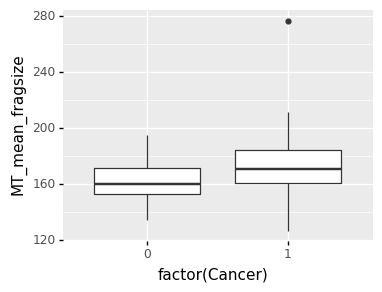

<ggplot: (8756877014297)>

In [33]:
ggplot(X_train)+aes(x='factor(Cancer)',y='MT_mean_fragsize') + geom_boxplot() + theme(figure_size=(4, 3))

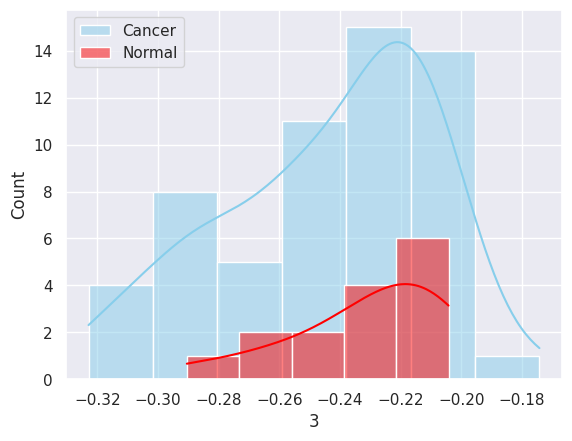

In [293]:
import seaborn as sns
import matplotlib.pyplot as plt


#fig, axes = plt.subplots(1, 2)

# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")

sns.histplot(x=X_train[X_train['Stage At Diagnosis'].isin(['Localized','Metastatic'])]['3'], color="skyblue", label="Cancer", kde=True)
sns.histplot(x=X_train[X_train['Stage At Diagnosis'] == 'Control']['3'], color="red", label="Normal", kde=True)

plt.legend() 
plt.show()

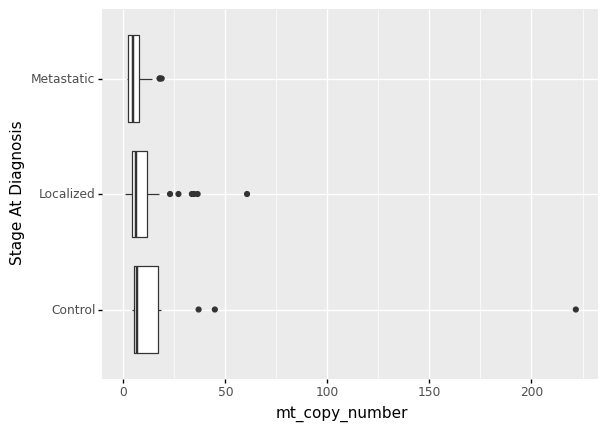

<ggplot: (8780378532109)>

In [283]:
ggplot(X_train) + aes(x='Stage At Diagnosis',y='mt_copy_number') + geom_boxplot() + coord_flip()

#### Modeling

In [863]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [865]:
#X_train.drop('Cancer',axis=1,inplace=True)

In [917]:
relevant_features = ['7_mean_fragsize','9_mean_fragsize','10_mean_fragsize','21_mean_fragsize','CMA_abnormal']

In [988]:
relevant_features = ['1_mean_fragsize', '2_mean_fragsize',
       '3_mean_fragsize', '4_mean_fragsize', '5_mean_fragsize',
       '6_mean_fragsize', '7_mean_fragsize', '8_mean_fragsize',
       '9_mean_fragsize', '10_mean_fragsize', '11_mean_fragsize',
       '12_mean_fragsize', '13_mean_fragsize', '14_mean_fragsize',
       '15_mean_fragsize', '16_mean_fragsize', '17_mean_fragsize',
       '18_mean_fragsize', '19_mean_fragsize', '20_mean_fragsize',
       '21_mean_fragsize', '22_mean_fragsize', 'MT_mean_fragsize']

In [989]:
X_train_final = X_train[relevant_features].values

In [990]:
X_test_final = X_test[relevant_features].values

In [995]:
def custom_cv(train_data,test_data,folds=2):
    split_index = round(X_train_final.shape[0]/folds)
    
    fold1_x = pd.DataFrame(train_data)[0:split_index]
    fold1_y = list(test_data)[0:split_index]

    fold2_x = pd.DataFrame(train_data)[split_index:]
    fold2_y = list(test_data)[split_index:]
    
    model1 = LogisticRegression(penalty='l1',solver='liblinear',max_iter=200,C=0.2,class_weight='balanced')
    model2 = LogisticRegression(penalty='l1',solver='liblinear',max_iter=200,C=0.2,class_weight='balanced')
    
    #model1 = LogisticRegression(class_weight='balanced')
    #model2 = LogisticRegression(class_weight='balanced')
    
    model1.fit(fold1_x,fold1_y)
    model2.fit(fold2_x,fold2_y)
    
    preds1_2 = np.array([1 if x[1] > 0.5 else 0 for x in model1.predict_proba(fold2_x)])
    preds2_1 = np.array([1 if x[1] > 0.5 else 0 for x in model2.predict_proba(fold1_x)])
    
    labels1 = np.array(fold1_y)
    labels2 = np.array(fold2_y)
    
    precision1 = metrics.precision_score(labels2,preds1_2)
    precision2 = metrics.precision_score(labels1,preds2_1)
    
    conf_mat1 = metrics.confusion_matrix(labels2,preds1_2)
    conf_mat2 = metrics.confusion_matrix(labels1,preds2_1)
    
    print(conf_mat1)
    print(conf_mat2)
    
    print(precision1,precision2)
    return model2.coef_


In [996]:
custom_cv(X_train_final,y_train)

[[ 1  7]
 [ 5 17]]
[[ 2  5]
 [ 7 16]]
0.7083333333333334 0.7619047619047619


/gpfs/fs1/home/cmunugala/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/gpfs/fs1/home/cmunugala/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.


array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.27830264,  0.        ,
         0.00767962, -0.03085853, -0.26774447,  0.        , -0.05418768,
         0.        ,  0.        ,  0.        ,  0.        ,  0.05563173,
         0.        ,  0.        ,  0.0123334 ]])

In [956]:
np.nonzero(custom_cv(X_train_final,y_train))

[[ 4  4]
 [ 6 23]]
[[ 4  3]
 [ 8 21]]
0.8518518518518519 0.875


(array([0, 0, 0, 0]), array([ 8, 10, 11, 22]))

In [957]:
np.nonzero(custom_cv(X_train_final,y_train))

[[ 4  4]
 [ 6 23]]
[[ 4  3]
 [ 8 21]]
0.8518518518518519 0.875


/gpfs/fs1/home/cmunugala/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/gpfs/fs1/home/cmunugala/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.


(array([0, 0, 0, 0]), array([ 8, 10, 11, 22]))

In [931]:
#model = LogisticRegression(penalty='l1',solver='liblinear',max_iter=300,C=0.1,class_weight='balanced')
model = LogisticRegression(class_weight='balanced')

In [932]:
model.fit(X_train_final,y_train)

LogisticRegression(class_weight='balanced')

In [933]:
preds = np.array([1 if x[1] > 0.5 else 0 for x in model.predict_proba(X_test_final)])

In [934]:
preds

array([1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0])

In [935]:
metrics.confusion_matrix(np.array(y_test),preds)

array([[ 3,  1],
       [ 5, 10]])

In [941]:
metrics.recall_score(np.array(y_test),preds)

0.6666666666666666

In [847]:
X_train['CMA result'].value_counts()

Abnormal           39
Control            15
Non-informative     8
Name: CMA result, dtype: int64

In [958]:
X_test

Sample ID       CPM.UID   Current.Label  \
38   CPM00021541-PL-D-20211105_20211202   CPM00021541      ctDNA-3N-4   
24   CPM00022115-PL-D-20220208_20220302   CPM00022115     ctDNA-2N-13   
83            CPM00012343-PL-D_20220330   CPM00012343         Control   
87            CPM00011382-PL-D_20220330   CPM00011382         Control   
69   CPM00022119-PL-D-20210910_20220302   CPM00022119  ctDNA-9N-7 (R)   
55   CPM00019098-PL-D-20210512_20211018   CPM00019098      ctDNA-7N-7   
80            CPM00017273-PL-D_20220330   CPM00017273         Control   
52  CPM00013846-PL-D-20201002_20211018   CPM00013846       ctDNA-7N-4   
17   CPM00007351-PL-D-20200204_20211202   CPM00007351     ctDNA-1R3-1   
65   CPM00011754-PL-D-20200708_20211027   CPM00011754      ctDNA-9N-3   
21   CPM00020143-PL-D-20210910_20211129   CPM00020143     ctDNA-2N-10   
44   CPM00019339-PL-D-20210709_20211129   CPM00019339      ctDNA-5N-4   
1             CPM00010023-PL-D_20210720   CPM00010023      ctDNA-1N-2   
40   CPM00013771-PL-D-20201008_20211027   CPM00013771      ctDNA-4N-2   
13   CPM00021797-PL-D-20211207_20220119   CPM00021797     ctDNA-1R1-4   
79            CPM00011387-PL-D_20220330   CPM00011387         Control   
56   CPM00009465-PL-D-20191011_20210901   CPM00009465     ctDNA-7R1-1   
8    CPM00021296-PL-D-20211020_20211129   CPM00021296      ctDNA-1N-9   
31   CPM00018811-PL-D-20210413_20211111   CPM00018811      ctDNA-2N-8   

    Date.drawn            Baseline.sample.Relapse     Timepoint CMA available  \
38   11/5/2021                    True baseline ü  At diagnosis           YES   
24    2/8/2022                      True Baseline  At diagnosis           YES   
83     Control                            Control       Control       Control   
87     Control                            Control       Control       Control   
69   9/10/2021    Post Surgery/Pre Chemo Baseline    On therapy            NO   
55   5/12/2021                    True Baseline ü  At diagnosis           YES   
80     Control                            Control       Control       Control   
52   10/2/2020                    True Baseline ü  At diagnosis           YES   
17    2/4/2020              True Baseline Relapse    At relapse           YES   
65    7/8/2020                    True Baseline ü  At diagnosis           YES   
21   9/10/2021                    Baseline/Pre C2    On therapy           YES   
44    7/9/2021  Pre Chemo/Post Surgery Baseline ü    On therapy           YES   
1     1/9/2020                     True Baseline   At diagnosis           YES   
40   10/8/2020                    True Baseline ü  At diagnosis           YES   
13   12/7/2021              True Baseline Relapse    At relapse            NO   
79     Control                            Control       Control       Control   
56  10/11/2019            True Baseline Relapse ü    At relapse           YES   
8   10/20/2021                     True Baseline   At diagnosis           YES   
31   4/13/2021                    True Baseline ü  At diagnosis            NO   

         CMA result   Profile.result Stage At Diagnosis  ... 17_mean_fragsize  \
38         Abnormal  Non-informative         Metastatic  ...       179.866000   
24         Abnormal         Abnormal          Localized  ...       169.640000   
83          Control  Non-informative            Control  ...       171.198000   
87          Control  Non-informative            Control  ...       187.740000   
69              NaN  Non-informative          Localized  ...       179.006000   
55         Abnormal         Abnormal         Metastatic  ...       174.970000   
80          Control  Non-informative            Control  ...       181.680000   
52         Abnormal         Abnormal          Localized  ...       154.436000   
17         Abnormal         Abnormal          Localized  ...       179.848000   
65         Abnormal         Abnormal         Metastatic  ...       179.166000   
21  Non-informative  Non-informative         Metastatic  